#1. UPLOAD DATASET

In [1]:
# BLOCK 1 — UPLOAD DATASET (Google Colab)
# What I am doing here:
#   - I am uploading my anime.csv dataset into Google Colab.
#   - Colab gives the file name after upload, so I store it in DATA_PATH.
# Why I need this:
#   - Without uploading the dataset, I cannot load it in pandas and work on it.

from google.colab import files

uploaded = files.upload()
DATA_PATH = next(iter(uploaded.keys()))
print("Using dataset:", DATA_PATH)


Saving anime.csv to anime.csv
Using dataset: anime.csv


#2. IMPORTING REQUIRED LIBRARIES

In [2]:
# BLOCK 2 — IMPORT REQUIRED LIBRARIES
# What I am doing here:
#   - Importing all the libraries that I need for this project.
# Libraries used:
#   - pandas, numpy: for data handling and calculations
#   - matplotlib: for visualizations and graphs
#   - sklearn: for recommendation algorithms and machine learning
#   - scipy.sparse: for combining TF-IDF text features with numeric features

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from scipy.sparse import hstack, csr_matrix


#3. LOAD DATASET AND UNDERSTAND IT

In [3]:
# BLOCK 3 — LOAD DATASET AND UNDERSTAND IT
# What I am doing here:
#   - Loading the dataset using pandas read_csv
#   - Checking the dataset shape (rows and columns)
#   - Viewing the first few rows using head()
#   - Checking the column datatypes using info()
# Why I am doing this:
#   - To understand what data is available and what columns I can use
#   - This helps me in feature selection and cleaning

df_raw = pd.read_csv(DATA_PATH)

print("Original Shape:", df_raw.shape)
display(df_raw.head())
display(df_raw.info())

print("\nColumns:", df_raw.columns.tolist())

# Numeric summary helps me understand the range of rating, members, etc.
print("\nNumeric Summary (describe):")
display(df_raw.describe(include=[np.number]).T)

# This shows what types of anime exist in the dataset like TV, Movie, OVA, etc.
if "type" in df_raw.columns:
    print("\nTop 10 'type' values:")
    display(df_raw["type"].value_counts().head(10))


Original Shape: (12294, 7)


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


None


Columns: ['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members']

Numeric Summary (describe):


,count,mean,std,min,25%,50%,75%,max
anime_id,12294.0,14058.221653,11455.294701,1.00,3484.25,10260.50,24794.50,34527.0
rating,12064.0,6.473902,1.026746,1.67,5.88,6.57,7.18,10.0
members,12294.0,18071.338864,54820.676925,5.00,225.00,1550.00,9437.00,1013917.0



Top 10 'type' values:


,count
type,
TV,3787
OVA,3311
Movie,2348
Special,1676
ONA,659
Music,488


#4. CHECK MISSING VALUES

Missing values (count):


,0
rating,230
genre,62
type,25


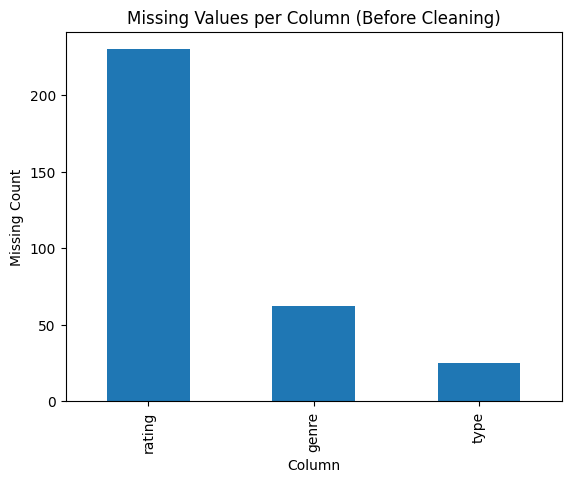

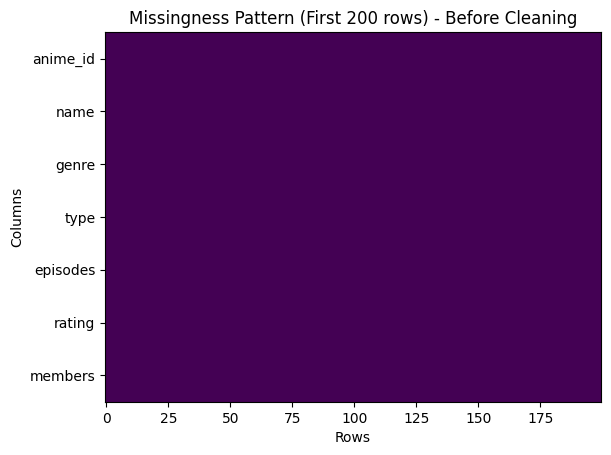

In [4]:
# BLOCK 4 — CHECK MISSING VALUES (BEFORE CLEANING)
# What I am doing here:
#   - Checking how many missing values are in each column
#   - Visualizing missing values with a bar chart
#   - Showing missingness pattern for first 200 rows
# Why I am doing this:
#   - Missing values can affect my recommendation results
#   - So I need to identify and handle them properly

df = df_raw.copy()

missing_before = df.isna().sum().sort_values(ascending=False)
print("Missing values (count):")
display(missing_before[missing_before > 0])

plt.figure()
(missing_before[missing_before > 0] if (missing_before > 0).any() else missing_before.head(1)).plot(kind="bar")
plt.title("Missing Values per Column (Before Cleaning)")
plt.xlabel("Column")
plt.ylabel("Missing Count")
plt.show()

plt.figure()
plt.imshow(df.isna().values[:200].T, aspect="auto")
plt.title("Missingness Pattern (First 200 rows) - Before Cleaning")
plt.xlabel("Rows")
plt.ylabel("Columns")
plt.yticks(range(len(df.columns)), df.columns)
plt.show()


#5. DATA CLEANING

In [5]:
# BLOCK 5 — DATA CLEANING
# What I am doing here:
#   1) Standardizing column names (so it becomes easy to use)
#   2) Removing duplicate rows (if any)
#   3) Converting episodes column into numeric values
#   4) Filtering invalid values (like rating outside 0-10)
#   5) Removing rows that have missing important values
# Why I am doing this:
#   - Cleaning makes the dataset more accurate
#   - It improves the recommendation quality

# (A) Standardize column names (just to avoid errors)
rename_map = {}
for c in df.columns:
    lc = c.strip().lower()
    if lc == "name": rename_map[c] = "name"
    elif lc == "genre": rename_map[c] = "genre"
    elif lc == "type": rename_map[c] = "type"
    elif lc in ["episodes", "episode"]: rename_map[c] = "episodes"
    elif lc == "rating": rename_map[c] = "rating"
    elif lc in ["members", "member"]: rename_map[c] = "members"
    elif lc in ["anime_id", "animeid", "id"]: rename_map[c] = "anime_id"

df = df.rename(columns=rename_map)

# Checking required columns
for req in ["name", "genre"]:
    if req not in df.columns:
        raise ValueError(f"Required column '{req}' not found. Columns: {df.columns.tolist()}")

# (B) Basic text cleaning
df["name"]  = df["name"].fillna("").astype(str).str.strip()
df["genre"] = df["genre"].fillna("").astype(str).str.strip()

if "type" in df.columns:
    df["type"] = df["type"].fillna("").astype(str).str.strip()

# (C) Remove duplicates
before_dup = df.shape[0]
df = df.drop_duplicates()

# If anime_id exists, it is safer to keep one unique anime_id
if "anime_id" in df.columns:
    df = df.drop_duplicates(subset=["anime_id"], keep="first")

after_dup = df.shape[0]
print("Duplicate Handling:")
print("  Rows before:", before_dup)
print("  Rows after: ", after_dup)
print("  Removed:    ", before_dup - after_dup)

# (D) Convert episodes into numeric values
# Sometimes episodes has "Unknown" or text, so I extract numbers
def clean_episodes(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    if s.lower() == "unknown":
        return np.nan
    m = re.search(r"\d+", s)
    return float(m.group()) if m else np.nan

if "episodes" in df.columns:
    df["episodes"] = df["episodes"].apply(clean_episodes)

# (E) Convert rating and members to numeric
if "rating" in df.columns:
    df["rating"] = pd.to_numeric(df["rating"], errors="coerce")

if "members" in df.columns:
    df["members"] = pd.to_numeric(df["members"], errors="coerce")

# (F) Filter invalid values
rows_before_invalid = df.shape[0]

# Rating should be between 0 and 10
if "rating" in df.columns:
    df = df[(df["rating"].isna()) | ((df["rating"] >= 0) & (df["rating"] <= 10))]

# Episodes should be > 0 (anime cannot have negative episodes)
if "episodes" in df.columns:
    df = df[(df["episodes"].isna()) | (df["episodes"] > 0)]

# Members should be >= 0
if "members" in df.columns:
    df = df[(df["members"].isna()) | (df["members"] >= 0)]

rows_after_invalid = df.shape[0]
print("\nInvalid Value Filtering:")
print("  Rows before:", rows_before_invalid)
print("  Rows after: ", rows_after_invalid)
print("  Removed:    ", rows_before_invalid - rows_after_invalid)

# (G) Remove rows with missing important values
rows_before_missing = df.shape[0]

# Name and genre must exist
df = df[df["name"].str.len() > 0]
df = df[df["genre"].str.len() > 0]

# For better recommendation, I am keeping only rows where rating and episodes exist
need_num = []
if "rating" in df.columns: need_num.append("rating")
if "episodes" in df.columns: need_num.append("episodes")

if need_num:
    df = df.dropna(subset=need_num)

rows_after_missing = df.shape[0]
print("\nMissing Value Handling:")
print("  Rows before:", rows_before_missing)
print("  Rows after: ", rows_after_missing)
print("  Removed:    ", rows_before_missing - rows_after_missing)

print("\nFinal Cleaned Shape:", df.shape)
display(df.head())


Duplicate Handling:
  Rows before: 12294
  Rows after:  12294
  Removed:     0

Invalid Value Filtering:
  Rows before: 12294
  Rows after:  12294
  Removed:     0

Missing Value Handling:
  Rows before: 12294
  Rows after:  11830
  Removed:     464

Final Cleaned Shape: (11830, 7)


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64.0,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24.0,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.16,151266


#6. VISUALIZATIONS AFTER CLEANING

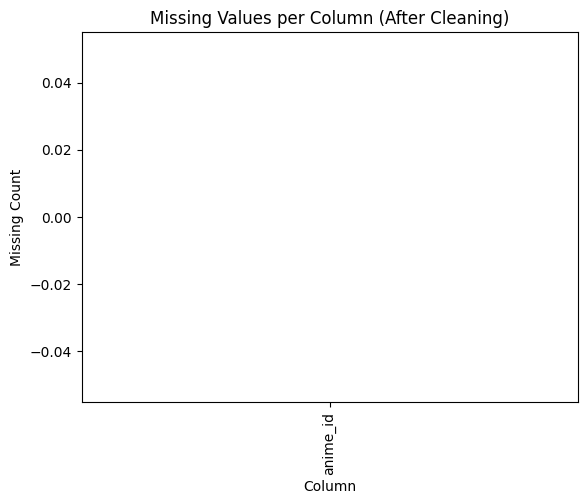

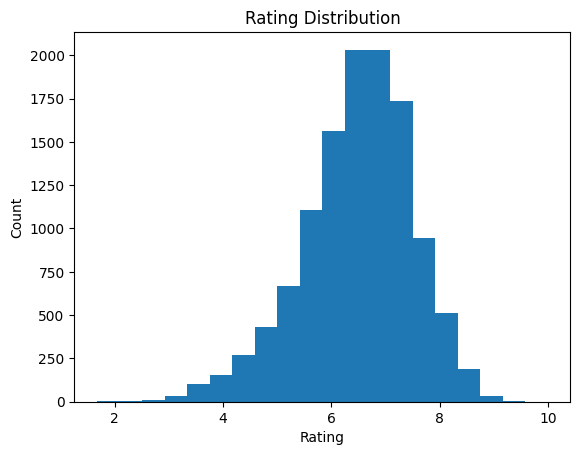

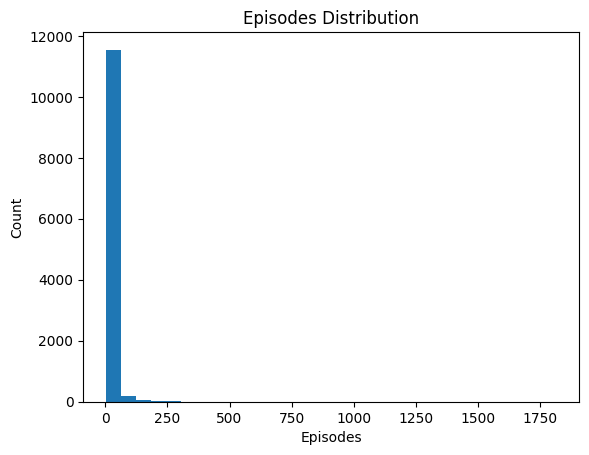

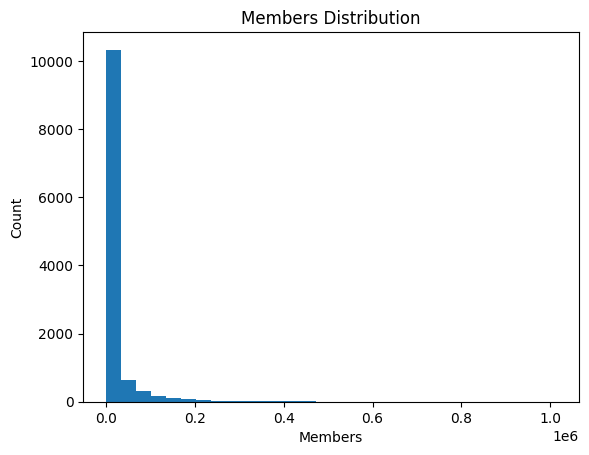

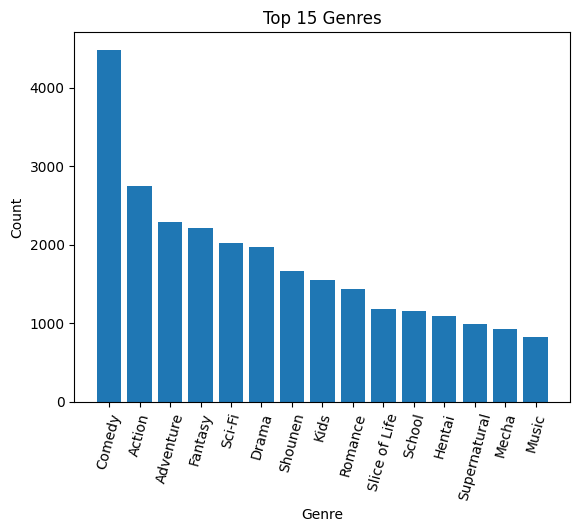

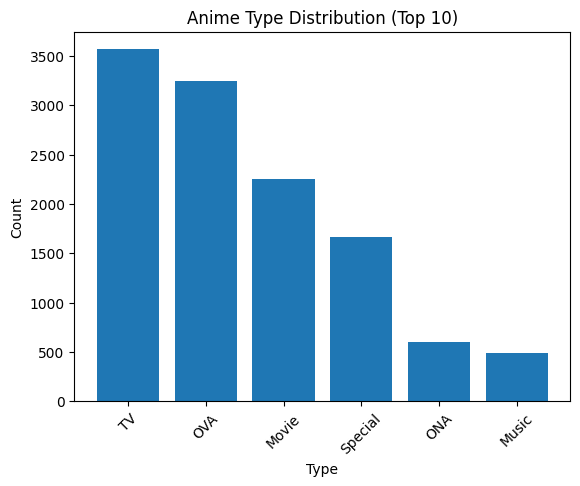

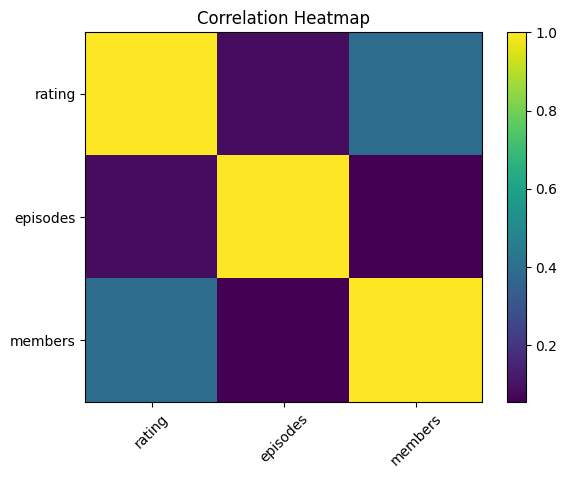

In [6]:
# BLOCK 6 — VISUALIZATIONS AFTER CLEANING
# What I am doing here:
#   - Creating different graphs to understand the dataset
# Graphs included:
#   - rating distribution
#   - episodes distribution
#   - members distribution
#   - top genres
#   - anime type count
#   - correlation heatmap
# Why I am doing this:
#   - Visualizations make it easier to explain the dataset in the report
#   - Also helps me understand patterns in the dataset

missing_after = df.isna().sum().sort_values(ascending=False)

plt.figure()
(missing_after[missing_after > 0] if (missing_after > 0).any() else missing_after.head(1)).plot(kind="bar")
plt.title("Missing Values per Column (After Cleaning)")
plt.xlabel("Column")
plt.ylabel("Missing Count")
plt.show()

if "rating" in df.columns:
    plt.figure()
    plt.hist(df["rating"], bins=20)
    plt.title("Rating Distribution")
    plt.xlabel("Rating")
    plt.ylabel("Count")
    plt.show()

if "episodes" in df.columns:
    plt.figure()
    plt.hist(df["episodes"], bins=30)
    plt.title("Episodes Distribution")
    plt.xlabel("Episodes")
    plt.ylabel("Count")
    plt.show()

if "members" in df.columns:
    plt.figure()
    plt.hist(df["members"], bins=30)
    plt.title("Members Distribution")
    plt.xlabel("Members")
    plt.ylabel("Count")
    plt.show()

# Top 15 genres
genre_series = df["genre"].str.split(",").explode().str.strip()
top_genres = genre_series.value_counts().head(15)

plt.figure()
plt.bar(top_genres.index, top_genres.values)
plt.title("Top 15 Genres")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=75)
plt.show()

# Anime type distribution
if "type" in df.columns:
    type_counts = df["type"].value_counts().head(10)
    plt.figure()
    plt.bar(type_counts.index, type_counts.values)
    plt.title("Anime Type Distribution (Top 10)")
    plt.xlabel("Type")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

# Correlation heatmap
num_cols = [c for c in ["rating", "episodes", "members"] if c in df.columns]
if len(num_cols) >= 2:
    corr = df[num_cols].corr()
    plt.figure()
    plt.imshow(corr.values, aspect="auto")
    plt.title("Correlation Heatmap")
    plt.xticks(range(len(num_cols)), num_cols, rotation=45)
    plt.yticks(range(len(num_cols)), num_cols)
    plt.colorbar()
    plt.show()


#7. FEATURE ENGINEERING (CONVERT TEXT TO NUMBERS)

In [7]:
# BLOCK 7 — FEATURE ENGINEERING (CONVERT TEXT TO NUMBERS)
# What I am doing here:
#   - ML models cannot understand text directly (like genre names)
#   - So I convert genre (and type) into TF-IDF vectors
#   - I also scale numeric features (rating and episodes)
# Output:
#   - Feature matrix X used for recommendation algorithms

text_field = df["genre"].astype(str)

# I am adding type as extra info because TV/Movie can also affect similarity
if "type" in df.columns:
    text_field = (df["genre"].astype(str) + " " + df["type"].astype(str)).str.strip()

tfidf = TfidfVectorizer(stop_words="english")
X_text = tfidf.fit_transform(text_field)

# Numeric features
num_feats = []
if "rating" in df.columns: num_feats.append("rating")
if "episodes" in df.columns: num_feats.append("episodes")

if num_feats:
    scaler = StandardScaler()
    X_num = scaler.fit_transform(df[num_feats].values)
    X = hstack([X_text, csr_matrix(X_num)]).tocsr()
else:
    X = X_text.tocsr()

print("Feature Matrix Shape:", X.shape)

# Title lookup dictionary
names = df["name"].tolist()
name_to_pos = {n.lower(): i for i, n in enumerate(names)}

def find_title(query):
    # First I try exact match, then I try partial match
    q = query.strip().lower()
    if q in name_to_pos:
        return names[name_to_pos[q]]
    matches = [n for n in names if q in n.lower()]
    return matches[0] if matches else None

def get_pos(title):
    return name_to_pos[title.lower()]


Feature Matrix Shape: (11830, 53)


#8. ALGORITHM 1: COSINE SIMILARITY RECOMMENDATION

In [8]:
# BLOCK 8 — ALGORITHM 1: COSINE SIMILARITY RECOMMENDATION
# What I am doing here:
#   - Using cosine similarity to compare anime feature vectors
#   - If similarity is high, it means anime are similar
# Why I chose this:
#   - It is simple and works well for content-based recommendation

def recommend_cosine(title, top_n=5):
    t = find_title(title)
    if not t:
        return None, "Title not found"
    i = get_pos(t)

    sims = cosine_similarity(X[i], X).flatten()
    sims[i] = -1  # remove itself from recommendations

    top_idx = np.argsort(sims)[::-1][:top_n]

    rec = df.iloc[top_idx][["name", "genre"]].copy()
    if "type" in df.columns:
        rec["type"] = df.iloc[top_idx]["type"].values
    rec["similarity"] = sims[top_idx]
    return t, rec


#9. ALGORITHM 2: KNN RECOMMENDATION

In [9]:
# BLOCK 9 — ALGORITHM 2: KNN RECOMMENDATION
# What I am doing here:
#   - Using NearestNeighbors (KNN) to find closest anime
#   - It uses cosine distance (smaller distance = more similar)
# Why I chose this:
#   - KNN is a common recommendation technique
#   - It is easy to implement and gives good results

knn = NearestNeighbors(metric="cosine", algorithm="brute")
knn.fit(X)

def recommend_knn(title, top_n=5):
    t = find_title(title)
    if not t:
        return None, "Title not found"
    i = get_pos(t)

    distances, indices = knn.kneighbors(X[i], n_neighbors=top_n + 1)
    distances = distances.flatten()
    indices = indices.flatten()

    # First result is the same anime, so I remove it
    distances = distances[1:]
    indices = indices[1:]

    rec = df.iloc[indices][["name", "genre"]].copy()
    if "type" in df.columns:
        rec["type"] = df.iloc[indices]["type"].values
    rec["distance"] = distances
    rec["similarity_est"] = 1 - distances
    return t, rec


#10. K-MEANS CLUSTERING + RECOMMENDATION

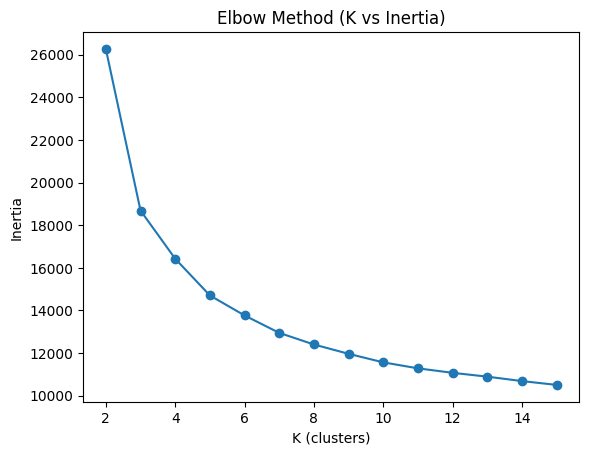

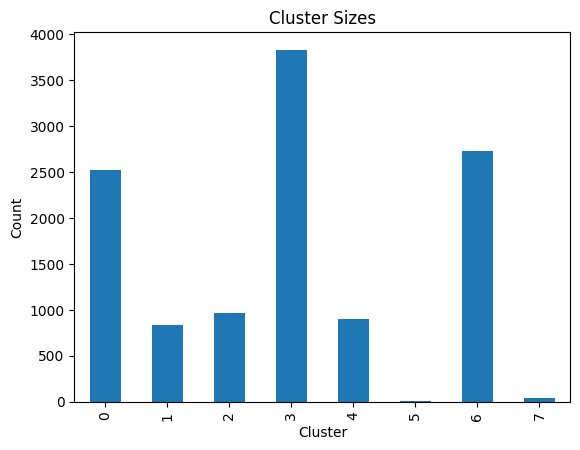

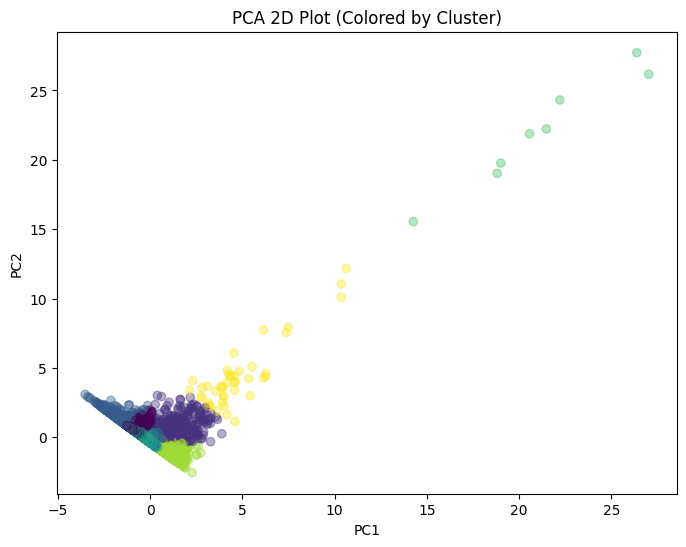

In [10]:
# BLOCK 10 — ALGORITHM 3: K-MEANS CLUSTERING + RECOMMENDATION
# What I am doing here:
#   - Grouping anime into clusters using K-Means
#   - Similar anime should be in the same cluster
#   - After clustering, I recommend anime from the same cluster
# Why I chose this:
#   - It is a machine learning approach that looks more advanced
#   - It helps reduce search space by focusing on similar groups

# Reduce features for clustering
safe_dense = (X.shape[0] * X.shape[1]) < 5_000_000
if safe_dense:
    X_dense = X.toarray()
    X_50 = PCA(n_components=50, random_state=42).fit_transform(X_dense)
else:
    from sklearn.decomposition import TruncatedSVD
    svd = TruncatedSVD(n_components=100, random_state=42)
    X_reduced = svd.fit_transform(X)
    X_50 = PCA(n_components=50, random_state=42).fit_transform(X_reduced)

# Elbow method
inertias = []
K_range = range(2, 16)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_50)
    inertias.append(km.inertia_)

plt.figure()
plt.plot(list(K_range), inertias, marker="o")
plt.title("Elbow Method (K vs Inertia)")
plt.xlabel("K (clusters)")
plt.ylabel("Inertia")
plt.show()

# Selecting K
K = 8
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(X_50)

# Cluster sizes
plt.figure()
df["cluster"].value_counts().sort_index().plot(kind="bar")
plt.title("Cluster Sizes")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()

# PCA 2D plot
X_2 = PCA(n_components=2, random_state=42).fit_transform(X_50)
plt.figure(figsize=(8, 6))
plt.scatter(X_2[:, 0], X_2[:, 1], c=df["cluster"], alpha=0.4)
plt.title("PCA 2D Plot (Colored by Cluster)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

def recommend_kmeans_cluster(title, top_n=5):
    t = find_title(title)
    if not t:
        return None, "Title not found"
    i = get_pos(t)

    c = df.iloc[i]["cluster"]

    # Find anime in the same cluster
    same_cluster_idx = df.index[df["cluster"] == c].to_numpy()

    sims = cosine_similarity(X[i], X[same_cluster_idx]).flatten()

    # Remove itself if present
    for j, real_idx in enumerate(same_cluster_idx):
        if real_idx == df.index[i]:
            sims[j] = -1

    top_local = np.argsort(sims)[::-1][:top_n]
    top_idx = same_cluster_idx[top_local]

    rec = df.loc[top_idx, ["name", "genre", "cluster"]].copy()
    if "type" in df.columns:
        rec["type"] = df.loc[top_idx]["type"].values
    rec["similarity"] = sims[top_local]
    return t, rec


#11. TEST THE RECOMMENDATION SYSTEM


QUERY ANIME: Naruto

[1] Cosine Similarity Recommendations


,name,genre,type,similarity
206,Dragon Ball Z,"Action, Adventure, Comedy, Fantasy, Martial Ar...",TV,0.996458
582,Bleach,"Action, Comedy, Shounen, Super Power, Supernat...",TV,0.983125
175,Katekyo Hitman Reborn!,"Action, Comedy, Shounen, Super Power",TV,0.978745
628,Keroro Gunsou,"Comedy, Sci-Fi, Shounen",TV,0.972297
346,Dragon Ball,"Adventure, Comedy, Fantasy, Martial Arts, Shou...",TV,0.970124


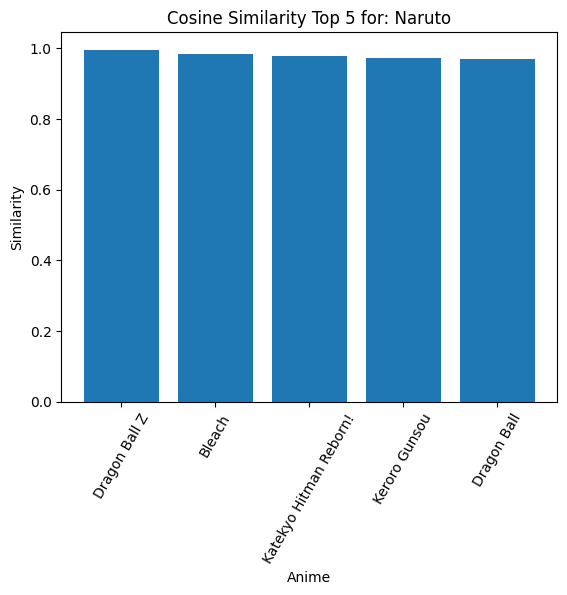


[2] KNN Recommendations


,name,genre,type,distance,similarity_est
206,Dragon Ball Z,"Action, Adventure, Comedy, Fantasy, Martial Ar...",TV,0.003542,0.996458
582,Bleach,"Action, Comedy, Shounen, Super Power, Supernat...",TV,0.016875,0.983125
175,Katekyo Hitman Reborn!,"Action, Comedy, Shounen, Super Power",TV,0.021255,0.978745
628,Keroro Gunsou,"Comedy, Sci-Fi, Shounen",TV,0.027703,0.972297
346,Dragon Ball,"Adventure, Comedy, Fantasy, Martial Arts, Shou...",TV,0.029876,0.970124


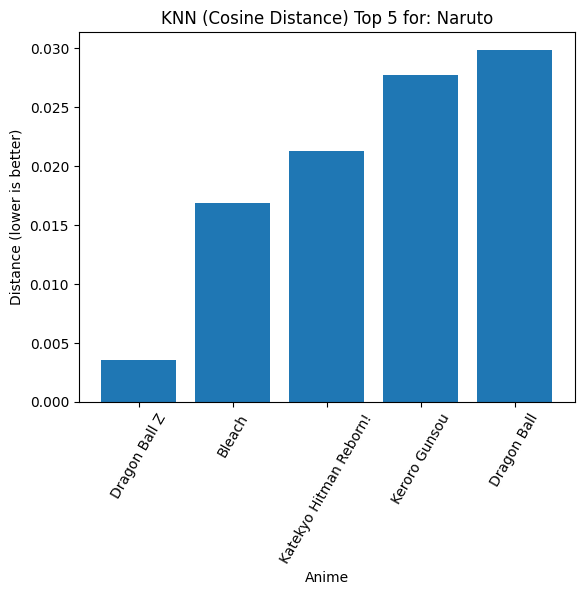


[3] K-Means Cluster + Cosine Recommendations


,name,genre,cluster,type,similarity
12,Gintama,"Action, Comedy, Historical, Parody, Samurai, S...",7,TV,0.930544
3314,Tottoko Hamtarou,"Adventure, Comedy, Kids",7,TV,0.656299
9317,Kotowaza House,"Comedy, Slice of Life",7,TV,0.644495
628,Keroro Gunsou,"Comedy, Sci-Fi, Shounen",7,TV,0.608461
2656,Pokemon Advanced Generation,"Action, Adventure, Comedy, Fantasy, Kids",7,TV,0.362617


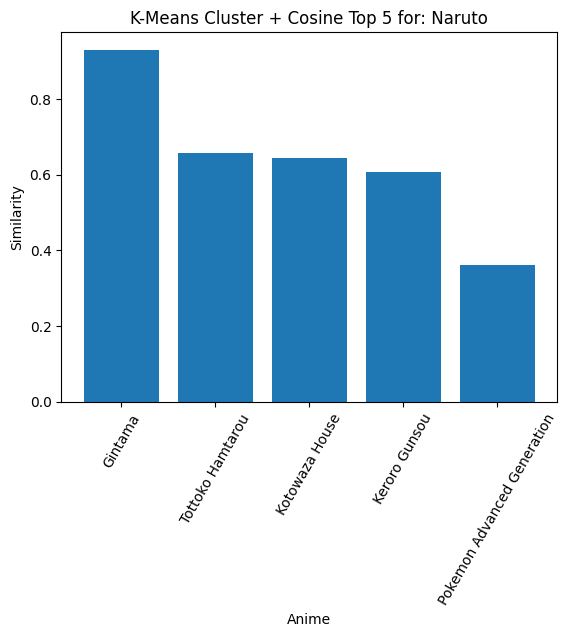


QUERY ANIME: Death Note

[1] Cosine Similarity Recommendations


,name,genre,type,similarity
144,Higurashi no Naku Koro ni Kai,"Mystery, Psychological, Supernatural, Thriller",TV,0.971676
334,Higurashi no Naku Koro ni,"Horror, Mystery, Psychological, Supernatural, ...",TV,0.950470
445,Mirai Nikki (TV),"Action, Mystery, Psychological, Shounen, Super...",TV,0.950112
981,Mousou Dairinin,"Drama, Mystery, Police, Psychological, Superna...",TV,0.939836
54,Re:Zero kara Hajimeru Isekai Seikatsu,"Drama, Fantasy, Psychological, Thriller",TV,0.936016


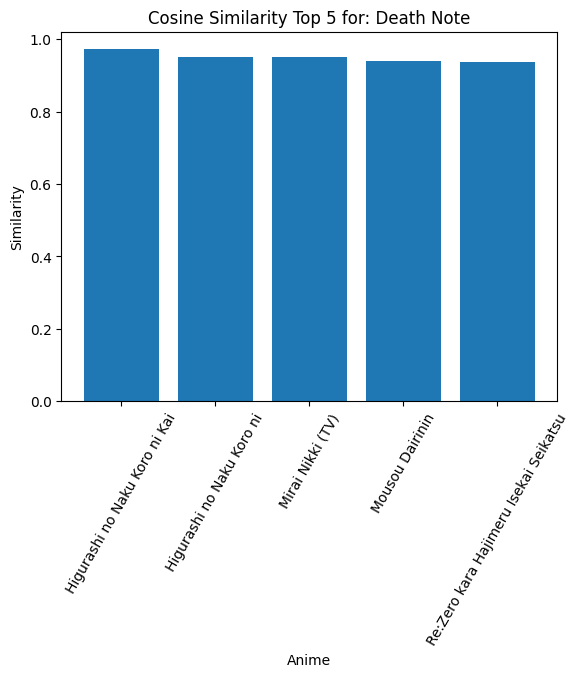


[2] KNN Recommendations


,name,genre,type,distance,similarity_est
144,Higurashi no Naku Koro ni Kai,"Mystery, Psychological, Supernatural, Thriller",TV,0.028324,0.971676
334,Higurashi no Naku Koro ni,"Horror, Mystery, Psychological, Supernatural, ...",TV,0.049530,0.950470
445,Mirai Nikki (TV),"Action, Mystery, Psychological, Shounen, Super...",TV,0.049888,0.950112
981,Mousou Dairinin,"Drama, Mystery, Police, Psychological, Superna...",TV,0.060164,0.939836
54,Re:Zero kara Hajimeru Isekai Seikatsu,"Drama, Fantasy, Psychological, Thriller",TV,0.063984,0.936016


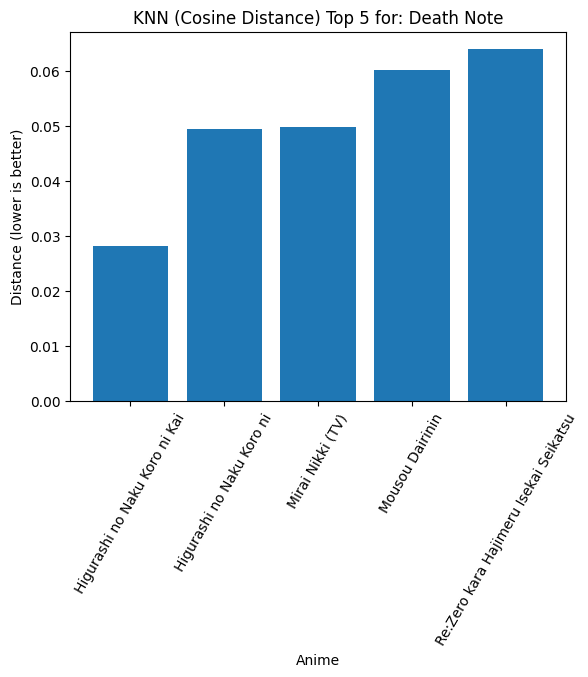


[3] K-Means Cluster + Cosine Recommendations


,name,genre,cluster,type,similarity
143,One Piece Film: Strong World,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",6,Movie,0.971676
332,Detective Conan Movie 18: The Sniper from Anot...,"Action, Mystery, Police, Shounen",6,Movie,0.950470
443,Kuroko no Basket: Tip Off,"Comedy, School, Shounen, Sports",6,Special,0.950112
978,Kekkai Sensen,"Action, Fantasy, Shounen, Super Power, Superna...",6,TV,0.939836
54,Re:Zero kara Hajimeru Isekai Seikatsu,"Drama, Fantasy, Psychological, Thriller",6,TV,0.936016


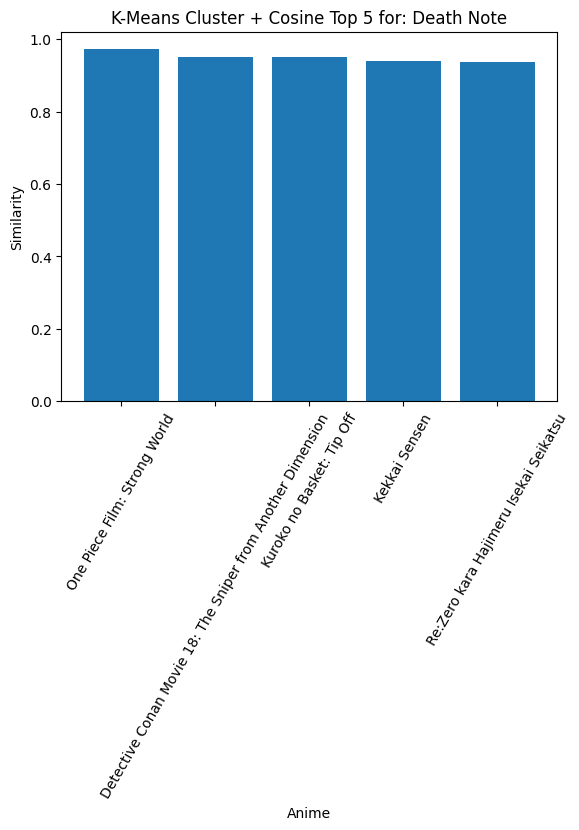


QUERY ANIME: One Piece

[1] Cosine Similarity Recommendations


,name,genre,type,similarity
163,One Piece Film: Z,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",Movie,0.999978
212,One Piece Film: Gold,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",Movie,0.999746
379,Digimon Adventure tri. 3: Kokuhaku,"Action, Adventure, Comedy, Drama",Movie,0.953516
24,Mononoke Hime,"Action, Adventure, Fantasy",Movie,0.952507
10191,Shenmi Shijie Lixian Ji,"Adventure, Comedy, Fantasy",Movie,0.947547


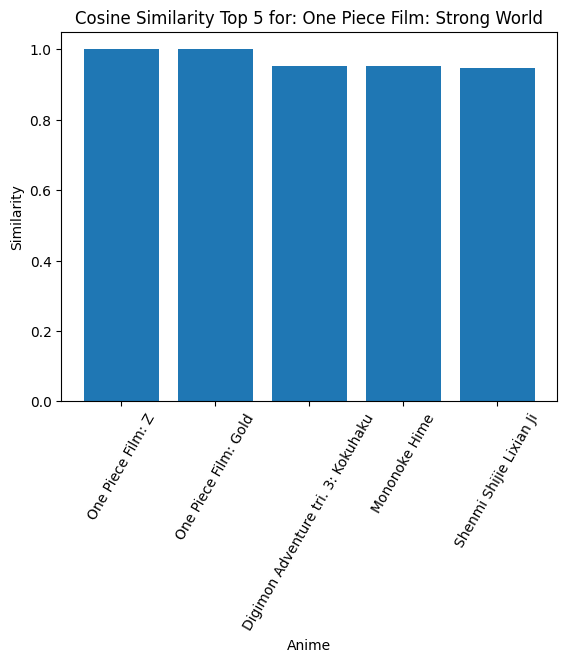


[2] KNN Recommendations


,name,genre,type,distance,similarity_est
163,One Piece Film: Z,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",Movie,0.000022,0.999978
212,One Piece Film: Gold,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",Movie,0.000254,0.999746
379,Digimon Adventure tri. 3: Kokuhaku,"Action, Adventure, Comedy, Drama",Movie,0.046484,0.953516
24,Mononoke Hime,"Action, Adventure, Fantasy",Movie,0.047493,0.952507
10191,Shenmi Shijie Lixian Ji,"Adventure, Comedy, Fantasy",Movie,0.052453,0.947547


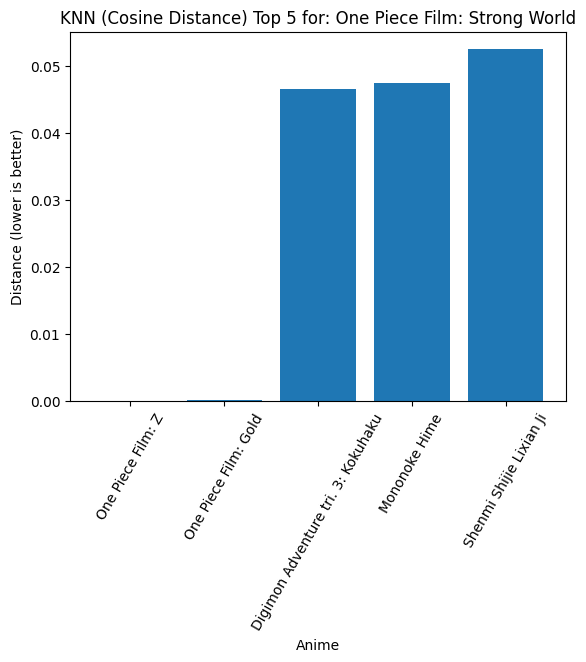


[3] K-Means Cluster + Cosine Recommendations


,name,genre,cluster,type,similarity
142,Natsume Yuujinchou,"Drama, Fantasy, Shoujo, Slice of Life, Superna...",6,TV,1.000000
162,Hajime no Ippo: Champion Road,"Comedy, Shounen, Sports",6,Special,0.999978
211,Neon Genesis Evangelion,"Action, Dementia, Drama, Mecha, Psychological,...",6,TV,0.999746
377,Aria The OVA: Arietta,"Fantasy, Sci-Fi, Shounen, Slice of Life",6,OVA,0.953516
24,Mononoke Hime,"Action, Adventure, Fantasy",6,Movie,0.952507


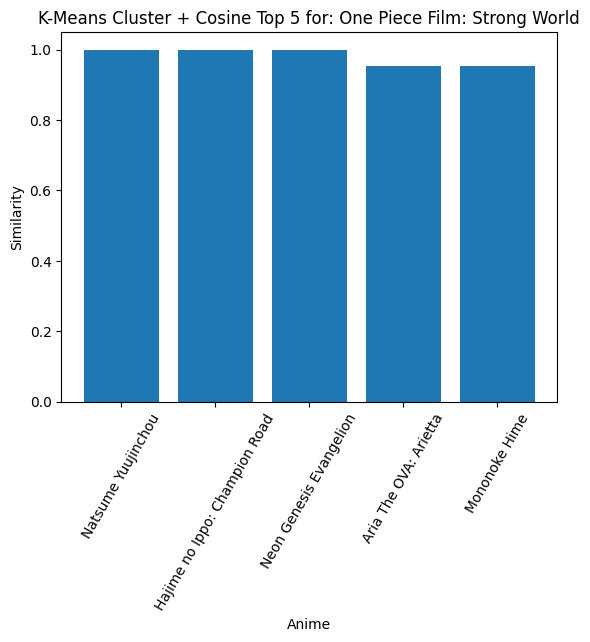


QUERY ANIME: Shingeki no Kyojin

[1] Cosine Similarity Recommendations


,name,genre,type,similarity
178,Boku no Hero Academia,"Action, Comedy, School, Shounen, Super Power",TV,0.948724
146,Hunter x Hunter: Greed Island Final,"Action, Adventure, Shounen, Super Power",OVA,0.945519
579,Shin Mazinger Shougeki! Z-hen,"Action, Mecha, Shounen, Super Power",TV,0.940110
717,Shingeki no Kyojin OVA,"Action, Drama, Fantasy, Shounen, Super Power",OVA,0.939729
13,Code Geass: Hangyaku no Lelouch R2,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",TV,0.939108


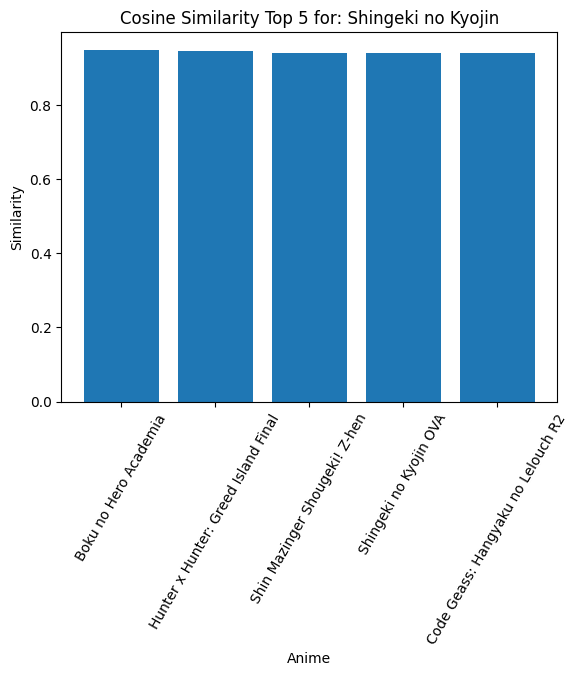


[2] KNN Recommendations


,name,genre,type,distance,similarity_est
178,Boku no Hero Academia,"Action, Comedy, School, Shounen, Super Power",TV,0.051276,0.948724
146,Hunter x Hunter: Greed Island Final,"Action, Adventure, Shounen, Super Power",OVA,0.054481,0.945519
579,Shin Mazinger Shougeki! Z-hen,"Action, Mecha, Shounen, Super Power",TV,0.059890,0.940110
717,Shingeki no Kyojin OVA,"Action, Drama, Fantasy, Shounen, Super Power",OVA,0.060271,0.939729
13,Code Geass: Hangyaku no Lelouch R2,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",TV,0.060892,0.939108


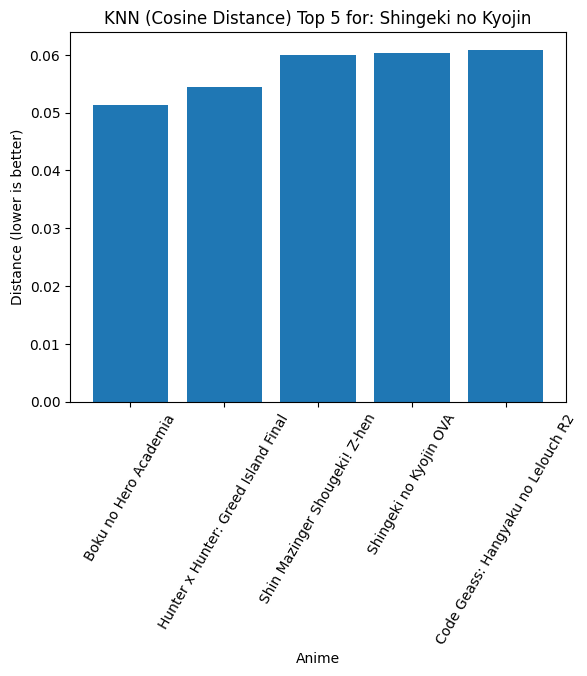


[3] K-Means Cluster + Cosine Recommendations


,name,genre,cluster,type,similarity
85,Mushishi Zoku Shou: Odoro no Michi,"Adventure, Fantasy, Historical, Mystery, Seine...",6,Special,1.000000
177,Ookami to Koushinryou,"Adventure, Fantasy, Historical, Romance",6,TV,0.948724
145,Hunter x Hunter OVA,"Action, Adventure, Shounen, Super Power",6,OVA,0.945519
714,Mind Game,"Adventure, Comedy, Dementia, Psychological, Ro...",6,Movie,0.939729
13,Code Geass: Hangyaku no Lelouch R2,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",6,TV,0.939108


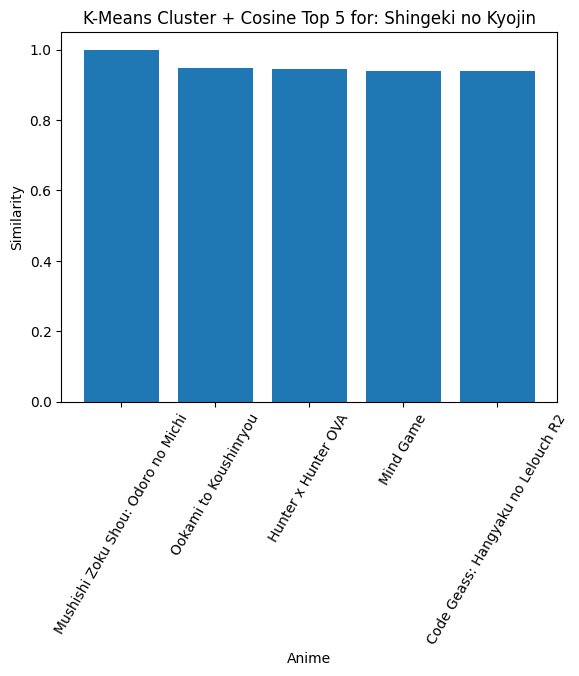


QUERY ANIME: Steins;Gate

[1] Cosine Similarity Recommendations


,name,genre,type,similarity
59,Steins;Gate Movie: Fuka Ryouiki no Déjà vu,"Sci-Fi, Thriller",Movie,0.962122
126,Steins;Gate: Oukoubakko no Poriomania,"Sci-Fi, Thriller",Special,0.954989
196,Steins;Gate: Kyoukaimenjou no Missing Link - D...,"Sci-Fi, Thriller",Special,0.949702
238,Gankutsuou,"Drama, Mystery, Sci-Fi, Supernatural, Thriller",TV,0.947622
36,Fate/Zero 2nd Season,"Action, Fantasy, Supernatural, Thriller",TV,0.944907


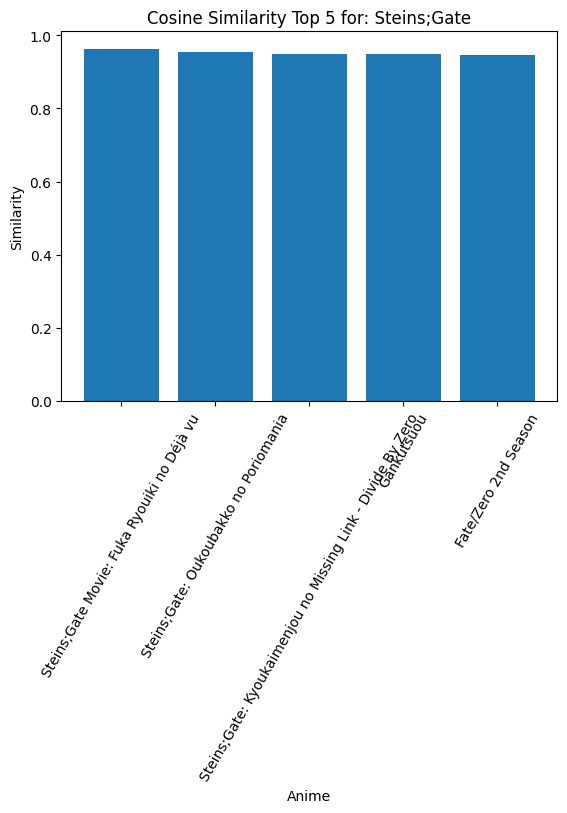


[2] KNN Recommendations


,name,genre,type,distance,similarity_est
59,Steins;Gate Movie: Fuka Ryouiki no Déjà vu,"Sci-Fi, Thriller",Movie,0.037878,0.962122
126,Steins;Gate: Oukoubakko no Poriomania,"Sci-Fi, Thriller",Special,0.045011,0.954989
196,Steins;Gate: Kyoukaimenjou no Missing Link - D...,"Sci-Fi, Thriller",Special,0.050298,0.949702
238,Gankutsuou,"Drama, Mystery, Sci-Fi, Supernatural, Thriller",TV,0.052378,0.947622
36,Fate/Zero 2nd Season,"Action, Fantasy, Supernatural, Thriller",TV,0.055093,0.944907


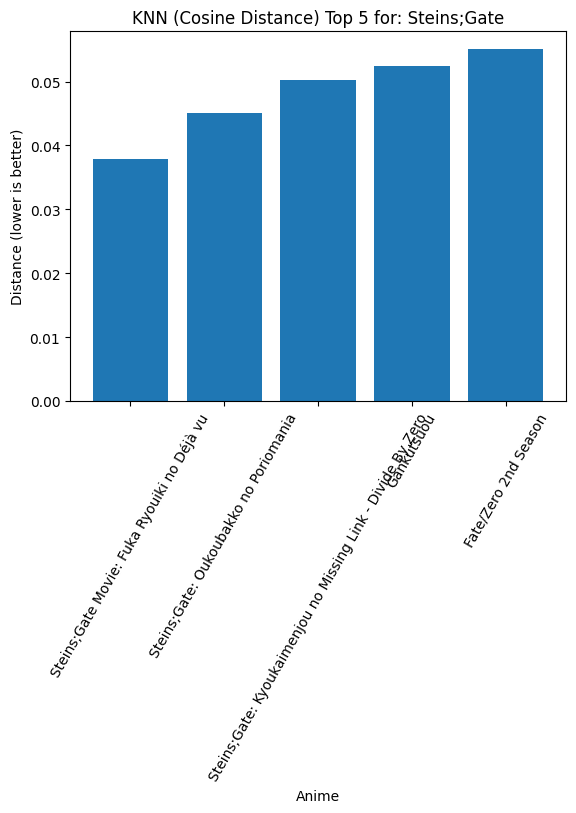


[3] K-Means Cluster + Cosine Recommendations


,name,genre,cluster,type,similarity
59,Steins;Gate Movie: Fuka Ryouiki no Déjà vu,"Sci-Fi, Thriller",6,Movie,0.962122
125,Shingeki no Kyojin: Kuinaki Sentaku,"Action, Fantasy, Shoujo, Supernatural",6,OVA,0.954989
195,Sennen Joyuu,"Action, Adventure, Drama, Fantasy, Historical,...",6,Movie,0.949702
237,Yowamushi Pedal: Grande Road,"Comedy, Drama, Shounen, Sports",6,TV,0.947622
36,Fate/Zero 2nd Season,"Action, Fantasy, Supernatural, Thriller",6,TV,0.944907


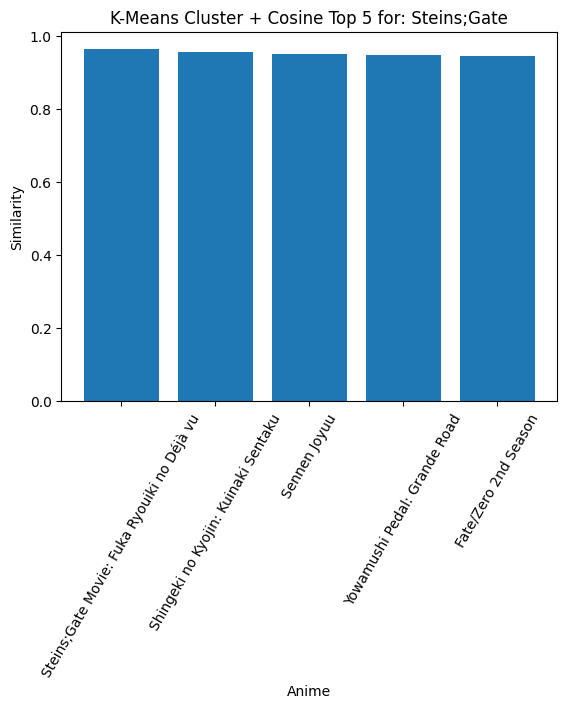

In [11]:
# BLOCK 11 — TEST THE RECOMMENDATION SYSTEM (5 ANIME, TOP 5 RESULTS)
# What I am doing here:
#   - Testing all 3 algorithms using 5 anime titles
#   - Printing the top 5 recommendations for each algorithm
#   - Plotting bar charts

TEST_TITLES = [
    "Naruto",
    "Death Note",
    "One Piece",
    "Shingeki no Kyojin",
    "Steins;Gate"
]

TOP_N = 5

def show_recommendations(title):
    print("\n" + "="*70)
    print("QUERY ANIME:", title)
    print("="*70)

    # Cosine Similarity
    t, rec_cos = recommend_cosine(title, top_n=TOP_N)
    if isinstance(rec_cos, str):
        print("Cosine Error:", rec_cos)
    else:
        print("\n[1] Cosine Similarity Recommendations")
        display(rec_cos)

        plt.figure()
        plt.bar(rec_cos["name"], rec_cos["similarity"])
        plt.title(f"Cosine Similarity Top {TOP_N} for: {t}")
        plt.xlabel("Anime")
        plt.ylabel("Similarity")
        plt.xticks(rotation=60)
        plt.show()

    # KNN
    t, rec_knn = recommend_knn(title, top_n=TOP_N)
    if isinstance(rec_knn, str):
        print("KNN Error:", rec_knn)
    else:
        print("\n[2] KNN Recommendations")
        display(rec_knn)

        plt.figure()
        plt.bar(rec_knn["name"], rec_knn["distance"])
        plt.title(f"KNN (Cosine Distance) Top {TOP_N} for: {t}")
        plt.xlabel("Anime")
        plt.ylabel("Distance (lower is better)")
        plt.xticks(rotation=60)
        plt.show()

    # K-Means
    t, rec_km = recommend_kmeans_cluster(title, top_n=TOP_N)
    if isinstance(rec_km, str):
        print("K-Means Error:", rec_km)
    else:
        print("\n[3] K-Means Cluster + Cosine Recommendations")
        display(rec_km)

        plt.figure()
        plt.bar(rec_km["name"], rec_km["similarity"])
        plt.title(f"K-Means Cluster + Cosine Top {TOP_N} for: {t}")
        plt.xlabel("Anime")
        plt.ylabel("Similarity")
        plt.xticks(rotation=60)
        plt.show()

for title in TEST_TITLES:
    show_recommendations(title)


#12 .FINAL SUMMARY



Most Frequently Recommended Anime (Across all tests & algorithms):


,anime,count
0,Keroro Gunsou,3
1,Re:Zero kara Hajimeru Isekai Seikatsu,3
2,Mononoke Hime,3
3,Code Geass: Hangyaku no Lelouch R2,3
4,Steins;Gate Movie: Fuka Ryouiki no Déjà vu,3
5,Fate/Zero 2nd Season,3
6,Dragon Ball Z,2
7,Bleach,2
8,Katekyo Hitman Reborn!,2
9,Dragon Ball,2


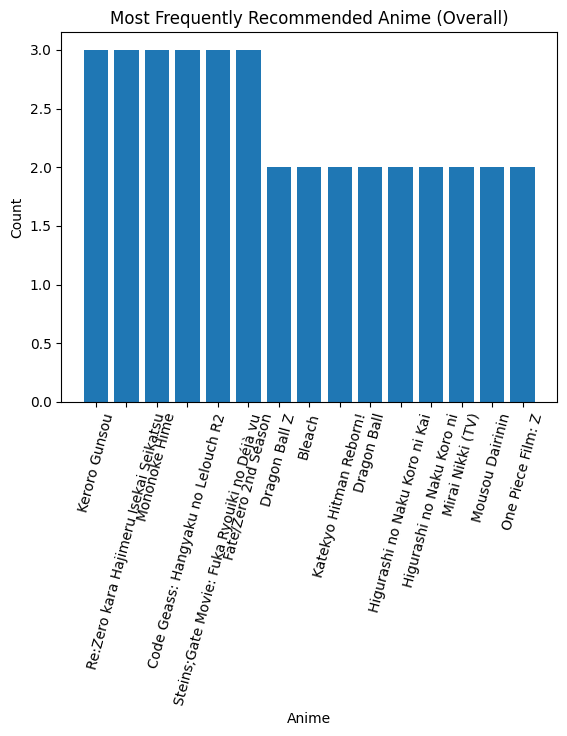

In [12]:
# BLOCK 12 — FINAL SUMMARY (MOST COMMONLY RECOMMENDED ANIME)
# What I am doing here:
#   - Collecting all recommendations from all algorithms
#   - Counting which anime appears most frequently
# Why I am doing this:
#   - It gives a nice summary result for my report conclusion

all_recs = []

for title in TEST_TITLES:
    _, r1 = recommend_cosine(title, top_n=TOP_N)
    _, r2 = recommend_knn(title, top_n=TOP_N)
    _, r3 = recommend_kmeans_cluster(title, top_n=TOP_N)

    if not isinstance(r1, str):
        all_recs += r1["name"].tolist()
    if not isinstance(r2, str):
        all_recs += r2["name"].tolist()
    if not isinstance(r3, str):
        all_recs += r3["name"].tolist()

counter = Counter(all_recs)
summary_df = pd.DataFrame(counter.most_common(15), columns=["anime", "count"])

print("\nMost Frequently Recommended Anime (Across all tests & algorithms):")
display(summary_df)

plt.figure()
plt.bar(summary_df["anime"], summary_df["count"])
plt.title("Most Frequently Recommended Anime (Overall)")
plt.xlabel("Anime")
plt.ylabel("Count")
plt.xticks(rotation=75)
plt.show()


#13. Visualization using seaborn

Silhouette Score (K=8): 0.1375


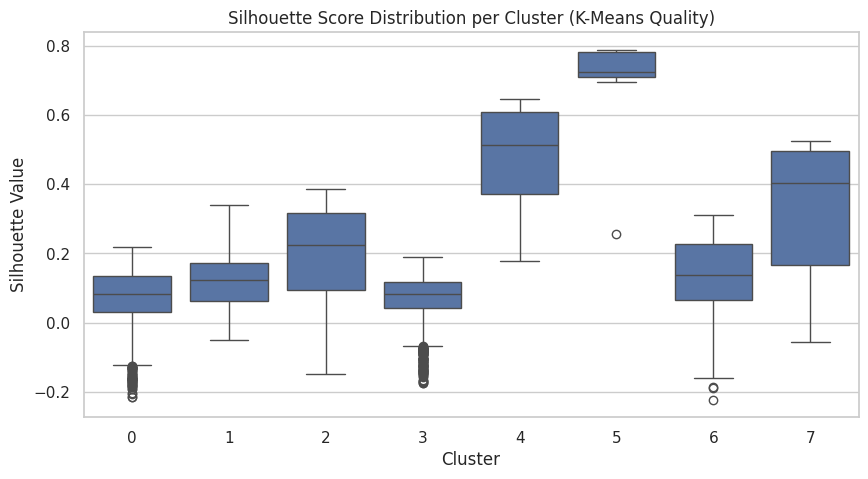

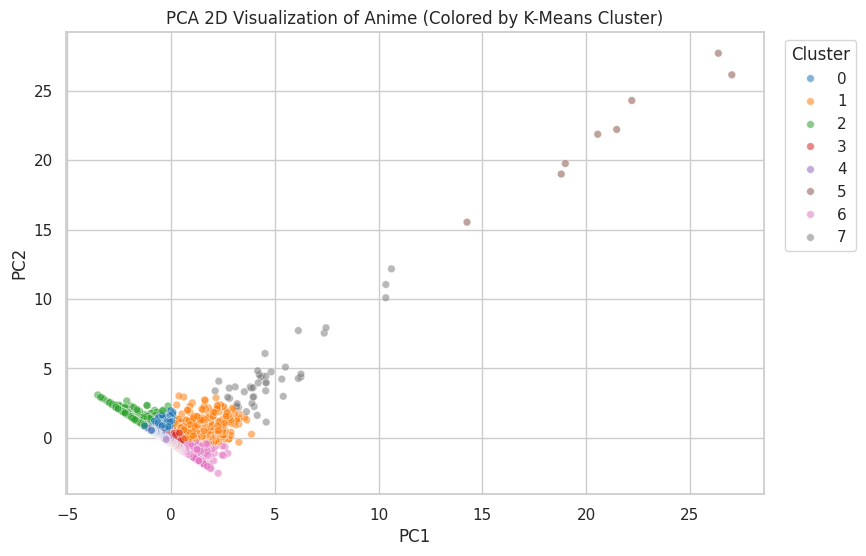

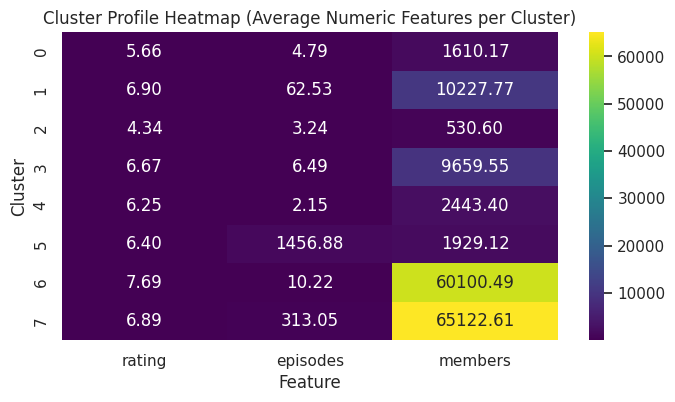

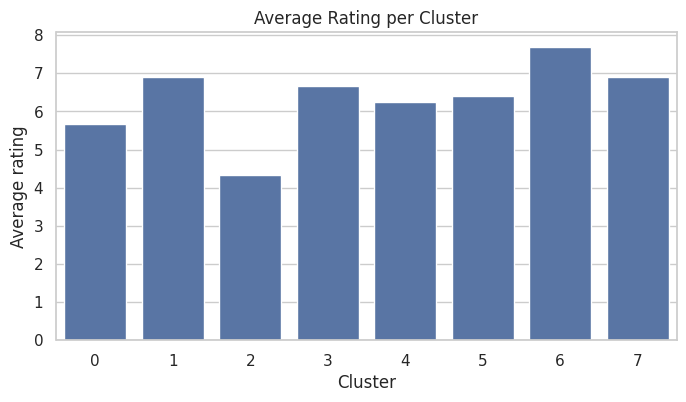

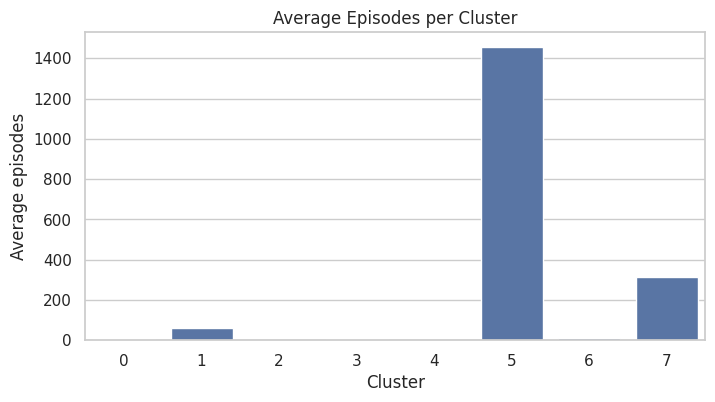

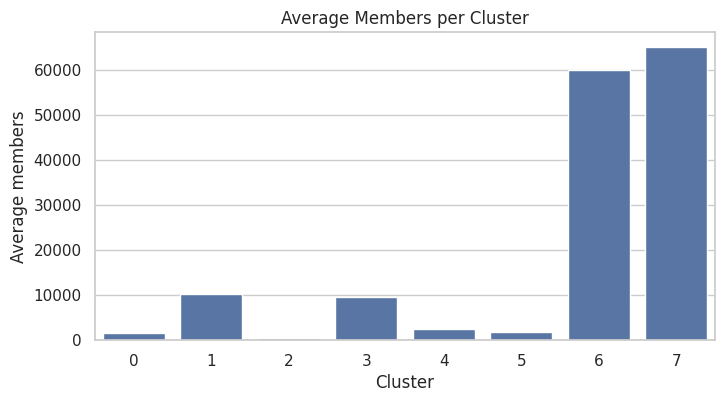

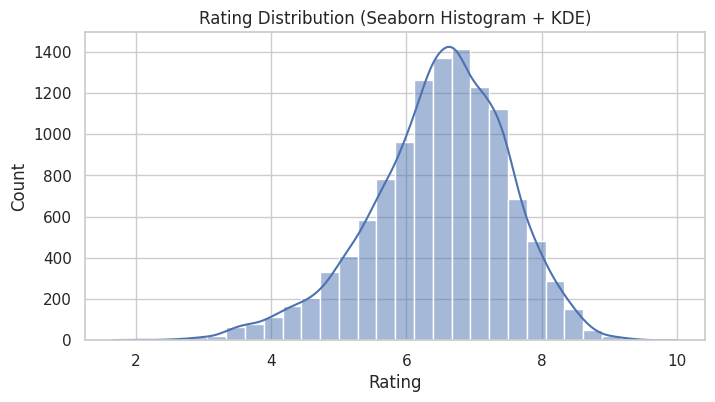

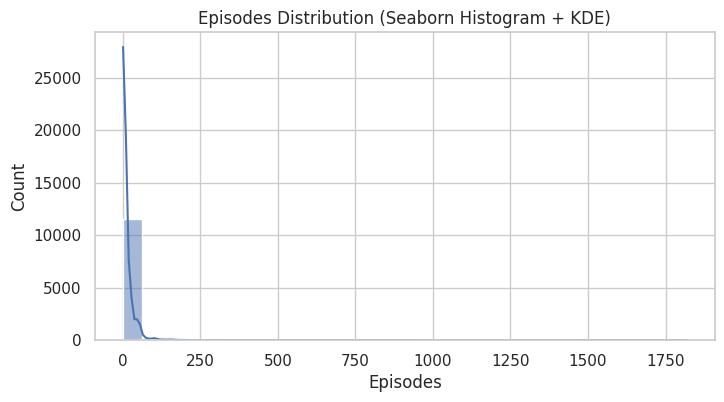

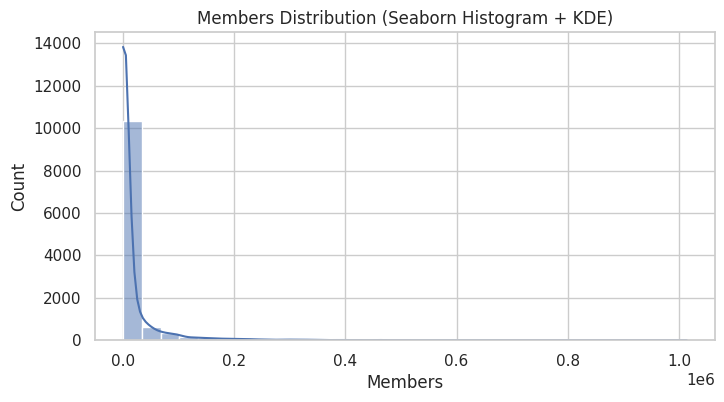

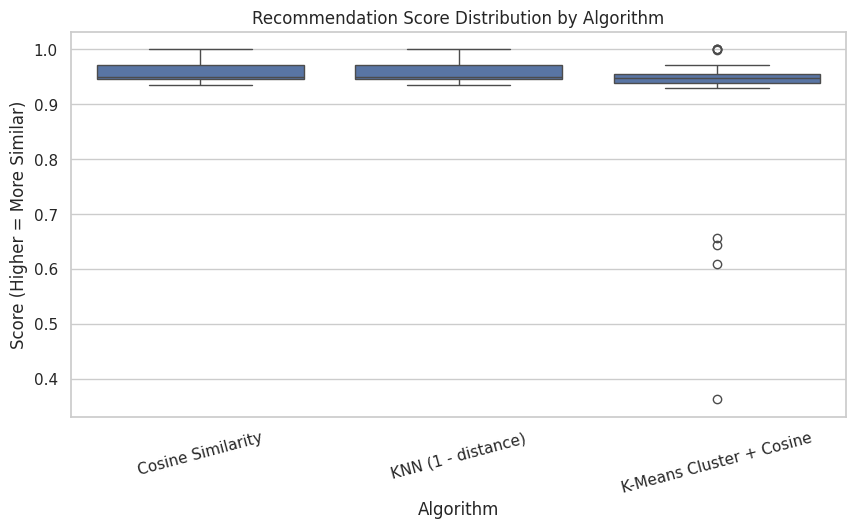

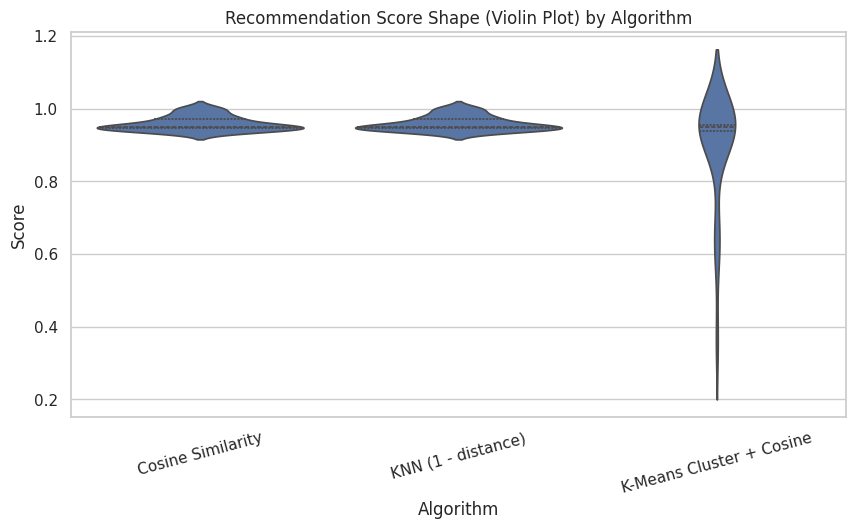

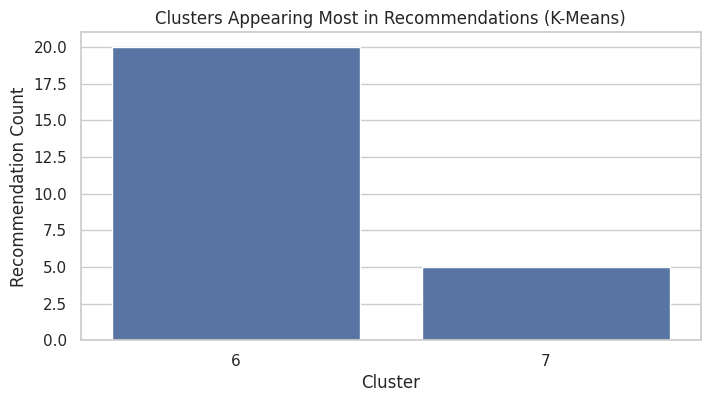

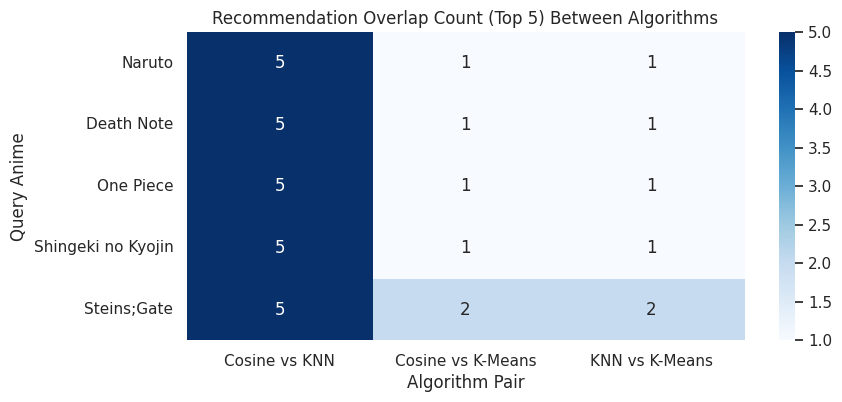

In [14]:
# BLOCK 13 — VISUALIZATIONS AFTER ALGORITHMS ARE APPLIED (Seaborn)
# What I am doing here:
#   - Visualizing results produced by the algorithms:
#       1) Cluster behavior (K-Means)
#       2) Feature-space separation (PCA scatter)
#       3) Cluster quality (silhouette plot)
#       4) Recommendation score distributions
#       5) Which clusters dominate recommendations
# Why I am doing this:
#   - These graphs prove the algorithms are working and help explain outcomes in report

import seaborn as sns
sns.set_theme(style="whitegrid")
from sklearn.metrics import silhouette_score, silhouette_samples

# (A) CLUSTER QUALITY: SILHOUETTE SCORE
# Silhouette score shows how well-separated the clusters are
# Range: -1 to +1 (higher is better)
if "cluster" in df.columns:
    sil = silhouette_score(X_50, df["cluster"])
    print(f"Silhouette Score (K={df['cluster'].nunique()}): {sil:.4f}")

    # Silhouette plot (distribution per cluster)
    sample_sil = silhouette_samples(X_50, df["cluster"])
    sil_df = pd.DataFrame({"cluster": df["cluster"], "silhouette": sample_sil})

    plt.figure(figsize=(10, 5))
    sns.boxplot(data=sil_df, x="cluster", y="silhouette")
    plt.title("Silhouette Score Distribution per Cluster (K-Means Quality)")
    plt.xlabel("Cluster")
    plt.ylabel("Silhouette Value")
    plt.show()

# (B) PCA SCATTER (better-looking seaborn)
if "cluster" in df.columns:
    try:
        X_2  # check if exists
    except NameError:
        X_2 = PCA(n_components=2, random_state=42).fit_transform(X_50)

    pca_vis = pd.DataFrame({
        "pc1": X_2[:, 0],
        "pc2": X_2[:, 1],
        "cluster": df["cluster"].astype(int)
    })

    plt.figure(figsize=(9, 6))
    sns.scatterplot(data=pca_vis, x="pc1", y="pc2", hue="cluster", palette="tab10", s=30, alpha=0.55)
    plt.title("PCA 2D Visualization of Anime (Colored by K-Means Cluster)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(title="Cluster", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.show()


# (C) CLUSTER PROFILE: AVG RATING / EPISODES PER CLUSTER
# Helps you explain what each cluster looks like
profile_cols = [c for c in ["rating", "episodes", "members"] if c in df.columns]
if "cluster" in df.columns and len(profile_cols) > 0:
    cluster_profile = df.groupby("cluster")[profile_cols].mean().reset_index()

    # Heatmap for quick overview
    plt.figure(figsize=(8, 4))
    sns.heatmap(cluster_profile.set_index("cluster"), annot=True, fmt=".2f", cmap="viridis")
    plt.title("Cluster Profile Heatmap (Average Numeric Features per Cluster)")
    plt.xlabel("Feature")
    plt.ylabel("Cluster")
    plt.show()

    # Bar plots per feature (report friendly)
    for col in profile_cols:
        plt.figure(figsize=(8, 4))
        sns.barplot(data=cluster_profile, x="cluster", y=col)
        plt.title(f"Average {col.capitalize()} per Cluster")
        plt.xlabel("Cluster")
        plt.ylabel(f"Average {col}")
        plt.show()

# (D) SEABORN HISTOGRAMS (YES, you can demonstrate histograms)
# Cleaner histograms + KDE (density curve)
for col in ["rating", "episodes", "members"]:
    if col in df.columns:
        plt.figure(figsize=(8, 4))
        sns.histplot(data=df, x=col, bins=30, kde=True)
        plt.title(f"{col.capitalize()} Distribution (Seaborn Histogram + KDE)")
        plt.xlabel(col.capitalize())
        plt.ylabel("Count")
        plt.show()

# (E) RECOMMENDATION SCORE DISTRIBUTION (Cosine vs KNN)
# For your TEST_TITLES, collect similarity scores and compare
algo_scores = []

for q in TEST_TITLES:
    # Cosine similarity scores
    t1, r1 = recommend_cosine(q, top_n=TOP_N)
    if not isinstance(r1, str):
        for s in r1["similarity"].values:
            algo_scores.append({"query": q, "algorithm": "Cosine Similarity", "score": s})

    # KNN similarity estimates (1 - distance)
    t2, r2 = recommend_knn(q, top_n=TOP_N)
    if not isinstance(r2, str):
        for s in r2["similarity_est"].values:
            algo_scores.append({"query": q, "algorithm": "KNN (1 - distance)", "score": s})

    # K-Means (cosine similarity inside cluster)
    t3, r3 = recommend_kmeans_cluster(q, top_n=TOP_N)
    if not isinstance(r3, str):
        for s in r3["similarity"].values:
            algo_scores.append({"query": q, "algorithm": "K-Means Cluster + Cosine", "score": s})

algo_scores_df = pd.DataFrame(algo_scores)

plt.figure(figsize=(10, 5))
sns.boxplot(data=algo_scores_df, x="algorithm", y="score")
plt.title("Recommendation Score Distribution by Algorithm")
plt.xlabel("Algorithm")
plt.ylabel("Score (Higher = More Similar)")
plt.xticks(rotation=15)
plt.show()

plt.figure(figsize=(10, 5))
sns.violinplot(data=algo_scores_df, x="algorithm", y="score", inner="quartile")
plt.title("Recommendation Score Shape (Violin Plot) by Algorithm")
plt.xlabel("Algorithm")
plt.ylabel("Score")
plt.xticks(rotation=15)
plt.show()


# (F) WHICH CLUSTERS APPEAR MOST IN RECOMMENDATIONS?
# Only works if you have clusters and K-Means recommendations produced
if "cluster" in df.columns:
    rec_clusters = []

    for q in TEST_TITLES:
        t3, r3 = recommend_kmeans_cluster(q, top_n=TOP_N)
        if not isinstance(r3, str):
            rec_clusters += r3["cluster"].astype(int).tolist()

    if len(rec_clusters) > 0:
        rec_cluster_counts = pd.Series(rec_clusters).value_counts().sort_index()

        plt.figure(figsize=(8, 4))
        sns.barplot(x=rec_cluster_counts.index, y=rec_cluster_counts.values)
        plt.title("Clusters Appearing Most in Recommendations (K-Means)")
        plt.xlabel("Cluster")
        plt.ylabel("Recommendation Count")
        plt.show()

# (G) RECOMMENDATION OVERLAP HEATMAP (Between Algorithms)
# What I am doing here:
#   - Checking how many recommended anime overlap between algorithms
#   - Showing overlap counts in a heatmap (Cosine vs KNN, Cosine vs K-Means, KNN vs K-Means)
# Why I am doing this:
#   - It proves consistency between algorithms and is easy to explain in viva

overlap_rows = []

for q in TEST_TITLES:
    _, r1 = recommend_cosine(q, top_n=TOP_N)
    _, r2 = recommend_knn(q, top_n=TOP_N)
    _, r3 = recommend_kmeans_cluster(q, top_n=TOP_N)

    set1 = set(r1["name"]) if not isinstance(r1, str) else set()
    set2 = set(r2["name"]) if not isinstance(r2, str) else set()
    set3 = set(r3["name"]) if not isinstance(r3, str) else set()

    overlap_rows.append({
        "query": q,
        "Cosine vs KNN": len(set1 & set2),
        "Cosine vs K-Means": len(set1 & set3),
        "KNN vs K-Means": len(set2 & set3),
    })

overlap_df = pd.DataFrame(overlap_rows).set_index("query")

plt.figure(figsize=(9, 4))
sns.heatmap(overlap_df, annot=True, fmt="d", cmap="Blues")
plt.title(f"Recommendation Overlap Count (Top {TOP_N}) Between Algorithms")
plt.xlabel("Algorithm Pair")
plt.ylabel("Query Anime")
plt.show()
